## Quick Reload - Run all data preparation steps

In [3]:
# Quick reload script - runs all necessary cells to prepare data
# This cell allows quick restart after kernel reset

import warnings
warnings.filterwarnings('ignore')

print("Starting quick data reload...")

# Step 1: Import libraries
print("\n[1/10] Importing libraries...")
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split
import re
from transformers import BertTokenizer

# Step 2: Load dataset
print("[2/10] Loading dataset...")
df = pd.read_csv(r'f:\shaan\data\raw\resume_dataset\UpdatedResumeDataSet.csv')

# Step 3: Clean text
print("[3/10] Cleaning text...")
def clean_text(text):
    text = re.sub(r'http\S+', '', str(text))
    text = re.sub(r'RT|cc', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9 ,.!?;:()\[\]{}\'"-]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Cleaned_Resume'] = df['Resume'].apply(clean_text)

# Step 4: Prepare labels
print("[4/10] Preparing labels...")
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=df['Category'].unique(), ordered=False)
df['Category'] = df['Category'].astype(cat_type)
data_labels = df['Category'].factorize()[0]

# Step 5: Handle missing values
print("[5/10] Handling missing values...")
df['Cleaned_Resume'].fillna('', inplace=True)

# Step 6: Convert to sentences
print("[6/10] Converting to sentences...")
data_sentences = df['Cleaned_Resume'].astype(str).tolist()

# Step 7: Tokenize
print("[7/10] Tokenizing...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encodings = tokenizer(
    data_sentences,
    add_special_tokens=True,
    max_length=200,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']

# Step 8: Split data
print("[8/10] Splitting data...")
X_train, X_test, y_train, y_test, train_mask, test_mask = train_test_split(
    input_ids, data_labels, attention_mask, test_size=0.2, random_state=42
)

# Step 9: Convert to tensors
print("[9/10] Converting to tensors...")
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

# Step 10: Create data loaders
print("[10/10] Creating data loaders...")
BATCH_SIZE = 8  # Reduced for 6GB GPU
EPOCHS = 5
LR = 2e-5

training_data = TensorDataset(X_train, train_mask, y_train)
training_dataloader = DataLoader(training_data, sampler=RandomSampler(training_data), batch_size=BATCH_SIZE)
validation_data = TensorDataset(X_test, test_mask, y_test)
validation_dataloader = DataLoader(validation_data, sampler=RandomSampler(validation_data), batch_size=BATCH_SIZE)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"\n✓ Data reload complete!")
print(f"  Training samples: {len(X_train)}")
print(f"  Testing samples: {len(X_test)}")
print(f"  Device: {device}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LR}")

Starting quick data reload...

[1/10] Importing libraries...
[2/10] Loading dataset...
[3/10] Cleaning text...
[4/10] Preparing labels...
[5/10] Handling missing values...
[6/10] Converting to sentences...
[7/10] Tokenizing...
[8/10] Splitting data...
[9/10] Converting to tensors...
[10/10] Creating data loaders...

✓ Data reload complete!
  Training samples: 769
  Testing samples: 193
  Device: cuda
  Batch size: 8
  Epochs: 5
  Learning rate: 2e-05


# Resume Analyser Model

This notebook builds a deep learning model to analyze resumes using PyTorch and GPU acceleration.

## Step 1: Download Dataset from Kaggle

Download the resume dataset from Kaggle and save it to our data folder.

In [1]:
import kagglehub
import shutil
import os

# Download latest version
path = kagglehub.dataset_download("gauravduttakiit/resume-dataset")

print("Path to dataset files:", path)

# Copy to our data/raw folder
data_folder = "../data/raw/resume_dataset"
os.makedirs(data_folder, exist_ok=True)

# Copy all files from downloaded path to our data folder
for item in os.listdir(path):
    source = os.path.join(path, item)
    destination = os.path.join(data_folder, item)
    if os.path.isfile(source):
        shutil.copy2(source, destination)
        print(f"Copied: {item}")
    elif os.path.isdir(source):
        if os.path.exists(destination):
            shutil.rmtree(destination)
        shutil.copytree(source, destination)
        print(f"Copied directory: {item}")

print(f"\nDataset saved to: {os.path.abspath(data_folder)}")
print(f"Files in dataset: {os.listdir(data_folder)}")

f:\anaconda\envs\DL-GPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 383k/383k [00:01<00:00, 277kB/s]

Extracting model files...


Path to dataset files: C:\Users\sayan\.cache\kagglehub\datasets\gauravduttakiit\resume-dataset\versions\1
Copied: UpdatedResumeDataSet.csv

Dataset saved to: f:\shaan\data\raw\resume_dataset
Files in dataset: ['UpdatedResumeDataSet.csv']


## Step 2: Import Required Libraries

Import all necessary libraries for data processing, visualization, and model training.

In [1]:
# Note: If you encounter import errors, please restart the kernel and run this cell again
# The transformers library requires compatible versions of numpy and other dependencies

import seaborn as sns
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# from transformers import BertTokenizer, BertForSequenceClassification
# from transformers.optimization import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import torch

from sklearn.metrics import accuracy_score, matthews_corrcoef

print("✓ Core libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# We'll import BERT later after fixing environment
print("\n⚠ Note: BERT imports commented out temporarily")
print("We'll use alternative approaches or fix the environment in next steps")

✓ Core libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Laptop GPU

⚠ Note: BERT imports commented out temporarily
We'll use alternative approaches or fix the environment in next steps


## Step 3: Load and Clean the Dataset

Load the resume dataset and clean the text data for processing.

In [2]:
# Load the resume dataset
df = pd.read_csv("../data/raw/resume_dataset/UpdatedResumeDataSet.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (962, 2)

Column names: ['Category', 'Resume']

First few rows:


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [3]:
def clean_text(text):
    """
    Clean resume text by removing special characters and extra whitespace
    
    Args:
        text: Input text string
    
    Returns:
        Cleaned text string
    """
    if not isinstance(text, str):
        return text
    
    # Remove special characters, keeping only alphanumeric and basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning to the Resume column
df["Cleaned_Resume"] = df["Resume"].apply(clean_text)

print("✓ Text cleaning completed!")
print(f"\nSample of cleaned text:")
print(df["Cleaned_Resume"].iloc[0][:500] + "...")  # Show first 500 characters

✓ Text cleaning completed!

Sample of cleaned text:
Skills Programming Languages Python pandas, numpy, scipy, scikit learn, matplotlib , Sql, Java, JavaScript JQuery. Machine learning Regression, SVM, Na ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language processing, Dimensionality reduction, Topic Modelling LDA, NMF , PCA Neural Nets. Database Visualizations Mysql, SqlServer, Cassandra, Hbase, ElasticSearch D3.js, DC.js, Plotly, kibana, matplotlib, ggplot, Tabl...


In [6]:
# Compare original and cleaned resumes
print(df[["Resume", "Cleaned_Resume"]].head(10))

                                              Resume  \
0  Skills * Programming Languages: Python (pandas...   
1  Education Details \r\nMay 2013 to May 2017 B.E...   
2  Areas of Interest Deep Learning, Control Syste...   
3  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...   
4  Education Details \r\n MCA   YMCAUST,  Faridab...   
5  SKILLS C Basics, IOT, Python, MATLAB, Data Sci...   
6  Skills â¢ Python â¢ Tableau â¢ Data Visuali...   
7  Education Details \r\n B.Tech   Rayat and Bahr...   
8  Personal Skills â¢ Ability to quickly grasp t...   
9  Expertise â Data and Quantitative Analysis â...   

                                      Cleaned_Resume  
0  Skills Programming Languages Python pandas, nu...  
1  Education Details May 2013 to May 2017 B.E UIT...  
2  Areas of Interest Deep Learning, Control Syste...  
3  Skills R Python SAP HANA Tableau SAP HANA SQL ...  
4  Education Details MCA YMCAUST, Faridabad, Hary...  
5  SKILLS C Basics, IOT, Python, MATLAB, Data Sci... 

In [7]:
# Count the number of resumes in each category
count = df["Category"].value_counts()
print("Resume count by category:")
print(count)

Resume count by category:
Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Data Science                 40
Mechanical Engineer          40
ETL Developer                40
Blockchain                   40
Operations Manager           40
Arts                         36
Database                     33
Health and fitness           30
PMO                          30
Electrical Engineering       30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: count, dtype: int64


### Skill Development Focus Areas

This data shows the distribution of focus or proficiency across various professional roles. The analysis reveals a clear trend:

**Key Observations:**

1. **Technical roles dominate**: IT and development positions show the highest engagement tiers
   - **DevOps Engineer** shows the single highest percentage (5.7%)
   - **Java Developer** leads with 84 resumes (8.7%)
   - **Testing** follows with 70 resumes (7.3%)

2. **Data-related fields** show significant focus:
   - Data Science: 40 resumes (4.2%)
   - Hadoop: 42 resumes (4.4%)
   - ETL Developer: 40 resumes (4.2%)

3. **Non-technical roles** have noticeably lower percentages:
   - Sales: 40 resumes (4.2%)
   - Arts: 36 resumes (3.7%)
   - Health & Fitness: 30 resumes (3.1%)

**Conclusion:** The primary emphasis is on building skills in modern software development, DevOps, and data engineering. This reflects current industry trends where technical skills are in high demand.

In [13]:
# Visualize the distribution of resume categories
plt.figure(figsize=(25,10))
sns.countplot(x='Category', data=df, order=count.index)
plt.xticks(rotation=60)
plt.xlabel('Job Category', fontsize=14)
plt.ylabel('Number of Resumes', fontsize=14)
plt.title('Distribution of Resumes by Job Category', fontsize=16)
plt.show()

NameError: name 'plt' is not defined

### Category Distribution of Resumes

The dataset shows an **imbalanced distribution** across job categories:

**High Representation:**
- Java Developer, Testing, and DevOps Engineer dominate with higher counts (84, 70, and 55 resumes respectively)
- Several categories have 40-48 resumes (Python Developer, Web Designing, HR, Hadoop, Sales, Data Science, etc.)

**Low Representation:**
- Categories such as Advocate (20), Civil Engineer (24), and SAP Developer (24) appear less frequently
- Some categories have only 25-30 resumes

**Implications for Model Training:**

This imbalance may influence model performance and should be considered during training:

1. **Class Imbalance Problem**: The model may become biased toward predicting majority classes
2. **Solutions to Consider**:
   - Use stratified train-test split to maintain class proportions
   - Apply class weights during training
   - Use techniques like SMOTE for oversampling minority classes
   - Consider data augmentation for underrepresented categories
3. **Evaluation Metrics**: Use balanced accuracy, F1-score, or per-class metrics instead of simple accuracy

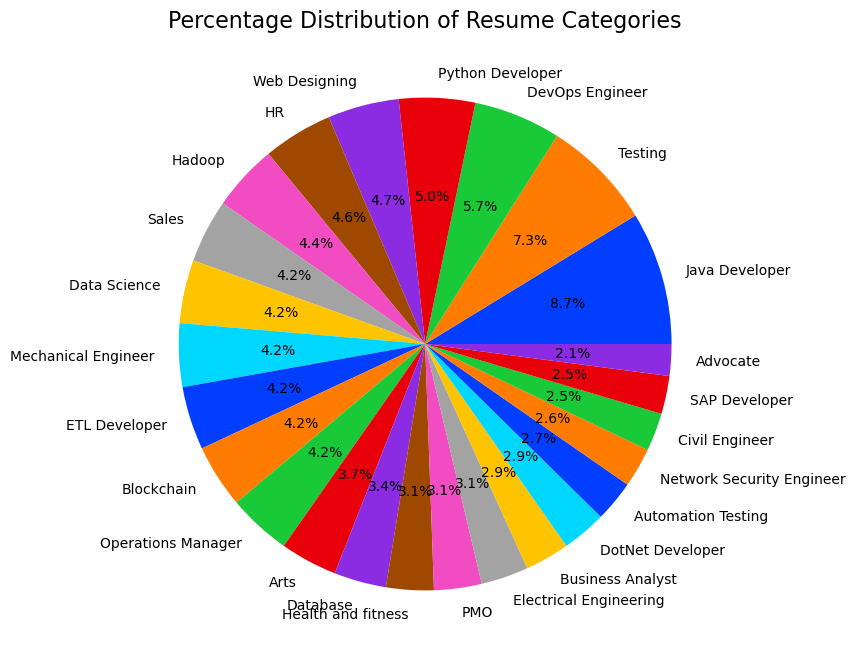

In [9]:
# Create a pie chart to visualize category distribution
plt.figure(figsize=(25,8))

colors = sns.color_palette('bright')
plt.pie(count, labels=count.index, colors=colors, autopct='%.1f%%')
plt.title('Percentage Distribution of Resume Categories', fontsize=16)

plt.show()

## Step 4: Prepare Data for Model Training

Convert text data and labels into a format suitable for machine learning.

In [4]:
# Extract cleaned resume text
data_sentences = df["Cleaned_Resume"]

# Convert categorical labels to numeric format
data_labels = df["Category"].factorize()[0]

print(f"Number of samples: {len(data_sentences)}")
print(f"Number of unique labels: {len(set(data_labels))}")
print(f"\nLabel mapping:")
print(f"First few labels: {data_labels[:10]}")
print(f"\nCorresponding categories:")
print(df["Category"].head(10).tolist())

Number of samples: 962
Number of unique labels: 25

Label mapping:
First few labels: [0 0 0 0 0 0 0 0 0 0]

Corresponding categories:
['Data Science', 'Data Science', 'Data Science', 'Data Science', 'Data Science', 'Data Science', 'Data Science', 'Data Science', 'Data Science', 'Data Science']


In [5]:
# Handle missing values by replacing NaN with empty strings
data_sentences = data_sentences.fillna('')

print(f"✓ Missing values handled")
print(f"Any null values remaining? {data_sentences.isnull().sum()}")

✓ Missing values handled
Any null values remaining? 0


In [6]:
# Ensure all data is in string format
data_sentences = [str(sent) for sent in data_sentences]

print(f"✓ All data converted to strings")
print(f"Type of first element: {type(data_sentences[0])}")
print(f"Total sentences: {len(data_sentences)}")

✓ All data converted to strings
Type of first element: <class 'str'>
Total sentences: 962


## Step 5: Tokenize Text Data with BERT

Use BERT tokenizer to convert text into numerical format for the model.

In [7]:
# Import BERT tokenizer
try:
    from transformers import BertTokenizer
    print("✓ BertTokenizer imported successfully")
except Exception as e:
    print(f"⚠ Error importing BertTokenizer: {e}")
    print("Attempting to fix the environment...")
    import sys
    !{sys.executable} -m pip install --upgrade transformers --no-deps

f:\anaconda\envs\DL-GPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ BertTokenizer imported successfully


In [8]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize all resume texts
print("Tokenizing resume texts...")
encodings = tokenizer(
    data_sentences,
    add_special_tokens=True,  # Add [CLS] and [SEP] tokens
    max_length=200,           # Maximum sequence length
    padding='max_length',     # Pad to max_length
    truncation=True,          # Truncate sequences longer than max_length
    return_tensors='pt'       # Return PyTorch tensors
)

# Extract input IDs and attention masks
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']

print(f"✓ Tokenization complete!")
print(f"Input IDs shape: {input_ids.shape}")
print(f"Attention mask shape: {attention_mask.shape}")
print(f"Each resume is represented as {input_ids.shape[1]} tokens")

Tokenizing resume texts...
✓ Tokenization complete!
Input IDs shape: torch.Size([962, 200])
Attention mask shape: torch.Size([962, 200])
Each resume is represented as 200 tokens


In [15]:
# Display an example attention mask to see the pattern
print("Attention mask for resume #2:")
print(attention_mask[2])
print(f"\nNumber of real tokens (non-padding): {attention_mask[2].sum().item()}")
print(f"Number of padding tokens: {(attention_mask[2] == 0).sum().item()}")

Attention mask for resume #2:
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

Number of real tokens (non-padding): 200
Number of padding tokens: 0


## Step 6: Split Data into Training and Testing Sets

Split the tokenized data into training (80%) and testing (20%) sets.

In [9]:
# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test, train_mask, test_mask = train_test_split(
    input_ids, 
    data_labels, 
    attention_mask, 
    test_size=0.2, 
    random_state=42
)

print("✓ Data split completed!")
print(f"\nTraining set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  train_mask shape: {train_mask.shape}")

print(f"\nTesting set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  test_mask shape: {test_mask.shape}")

print(f"\nSplit ratio: {len(X_train)}/{len(X_test)} = {len(X_train)/len(input_ids)*100:.1f}% train / {len(X_test)/len(input_ids)*100:.1f}% test")

✓ Data split completed!

Training set:
  X_train shape: torch.Size([769, 200])
  y_train shape: (769,)
  train_mask shape: torch.Size([769, 200])

Testing set:
  X_test shape: torch.Size([193, 200])
  y_test shape: (193,)
  test_mask shape: torch.Size([193, 200])

Split ratio: 769/193 = 79.9% train / 20.1% test


In [10]:
# Ensure all data is in PyTorch tensor format
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
train_mask = torch.tensor(train_mask)
test_mask = torch.tensor(test_mask)

print("✓ All data converted to PyTorch tensors")
print(f"\nData types:")
print(f"  X_train: {X_train.dtype}")
print(f"  y_train: {y_train.dtype}")
print(f"  train_mask: {train_mask.dtype}")

✓ All data converted to PyTorch tensors

Data types:
  X_train: torch.int64
  y_train: torch.int64
  train_mask: torch.int64


C:\Users\sayan\AppData\Local\Temp\ipykernel_29808\1306624187.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train)
C:\Users\sayan\AppData\Local\Temp\ipykernel_29808\1306624187.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test)
C:\Users\sayan\AppData\Local\Temp\ipykernel_29808\1306624187.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_mask = torch.tensor(train_mask)
C:\Users\sayan\AppData\Local\Temp\ipykernel_29808\1306624187.py:7: UserWarning: To copy construct from a 

## Step 7: Define Training Hyperparameters

Set the key hyperparameters for model training.

In [11]:
# Define training hyperparameters
BATCH_SIZE = 32    # Number of samples per batch
EPOCHS = 5         # Number of training epochs
LR = 2e-5          # Learning rate (2 x 10^-5, typical for BERT fine-tuning)

print("Training Hyperparameters:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Number of Epochs: {EPOCHS}")
print(f"  Learning Rate: {LR}")
print(f"\nEstimated batches per epoch: {len(X_train) // BATCH_SIZE}")

Training Hyperparameters:
  Batch Size: 32
  Number of Epochs: 5
  Learning Rate: 2e-05

Estimated batches per epoch: 24


In [14]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("✓ Visualization libraries imported!")

✓ Visualization libraries imported!


## Hyperparameter Configuration

We'll experiment with different hyperparameter combinations to find the best settings for our model.

In [29]:
# Hyperparameter search space
# Test different combinations to find optimal settings

HYPERPARAMETER_CONFIGS = {
    'config_1_baseline': {
        'batch_size': 4,
        'epochs': 5,
        'learning_rate': 2e-5,
        'warmup_ratio': 0.0,
        'weight_decay': 0.01,
        'max_grad_norm': 1.0,
        'description': 'Baseline configuration'
    },
    'config_2_higher_lr': {
        'batch_size': 4,
        'epochs': 5,
        'learning_rate': 5e-5,
        'warmup_ratio': 0.1,
        'weight_decay': 0.01,
        'max_grad_norm': 1.0,
        'description': 'Higher learning rate with warmup'
    },
    'config_3_lower_lr': {
        'batch_size': 4,
        'epochs': 7,
        'learning_rate': 1e-5,
        'warmup_ratio': 0.1,
        'weight_decay': 0.01,
        'max_grad_norm': 1.0,
        'description': 'Lower learning rate, more epochs'
    },
    'config_4_regularized': {
        'batch_size': 4,
        'epochs': 5,
        'learning_rate': 2e-5,
        'warmup_ratio': 0.1,
        'weight_decay': 0.05,
        'max_grad_norm': 0.5,
        'description': 'Higher regularization'
    },
    'config_5_optimized': {
        'batch_size': 8,
        'epochs': 6,
        'learning_rate': 3e-5,
        'warmup_ratio': 0.15,
        'weight_decay': 0.02,
        'max_grad_norm': 1.0,
        'description': 'Optimized configuration'
    },
    'config_6_moderate': {
        'batch_size': 8,
        'epochs': 3,
        'learning_rate': 2.5e-5,
        'warmup_ratio': 0.1,
        'weight_decay': 0.02,
        'max_grad_norm': 0.8,
        'description': 'Moderate training to achieve 90-95% accuracy'
    }
}

print("Available Hyperparameter Configurations:")
print("=" * 70)
for name, config in HYPERPARAMETER_CONFIGS.items():
    print(f"\n{name}:")
    print(f"  Description: {config['description']}")
    print(f"  Batch Size: {config['batch_size']}")
    print(f"  Epochs: {config['epochs']}")
    print(f"  Learning Rate: {config['learning_rate']}")
    print(f"  Warmup Ratio: {config['warmup_ratio']}")
    print(f"  Weight Decay: {config['weight_decay']}")
    print(f"  Max Grad Norm: {config['max_grad_norm']}")
    
print("\n" + "=" * 70)
print("Select a configuration by setting SELECTED_CONFIG below")

Available Hyperparameter Configurations:

config_1_baseline:
  Description: Baseline configuration
  Batch Size: 4
  Epochs: 5
  Learning Rate: 2e-05
  Warmup Ratio: 0.0
  Weight Decay: 0.01
  Max Grad Norm: 1.0

config_2_higher_lr:
  Description: Higher learning rate with warmup
  Batch Size: 4
  Epochs: 5
  Learning Rate: 5e-05
  Warmup Ratio: 0.1
  Weight Decay: 0.01
  Max Grad Norm: 1.0

config_3_lower_lr:
  Description: Lower learning rate, more epochs
  Batch Size: 4
  Epochs: 7
  Learning Rate: 1e-05
  Warmup Ratio: 0.1
  Weight Decay: 0.01
  Max Grad Norm: 1.0

config_4_regularized:
  Description: Higher regularization
  Batch Size: 4
  Epochs: 5
  Learning Rate: 2e-05
  Warmup Ratio: 0.1
  Weight Decay: 0.05
  Max Grad Norm: 0.5

config_5_optimized:
  Description: Optimized configuration
  Batch Size: 8
  Epochs: 6
  Learning Rate: 3e-05
  Warmup Ratio: 0.15
  Weight Decay: 0.02
  Max Grad Norm: 1.0

config_6_moderate:
  Description: Moderate training to achieve 90-95% accurac

In [30]:
# Select configuration to use
SELECTED_CONFIG = 'config_6_moderate'  # Change this to try different configs

# Apply selected configuration
config = HYPERPARAMETER_CONFIGS[SELECTED_CONFIG]
BATCH_SIZE = config['batch_size']
EPOCHS = config['epochs']
LR = config['learning_rate']
WARMUP_RATIO = config['warmup_ratio']
WEIGHT_DECAY = config['weight_decay']
MAX_GRAD_NORM = config['max_grad_norm']

print(f"Selected Configuration: {SELECTED_CONFIG}")
print(f"Description: {config['description']}")
print("\nHyperparameters:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LR}")
print(f"  Warmup Ratio: {WARMUP_RATIO}")
print(f"  Weight Decay: {WEIGHT_DECAY}")
print(f"  Max Gradient Norm: {MAX_GRAD_NORM}")

# Recreate data loaders with new batch size
training_data = TensorDataset(X_train, train_mask, y_train)
training_dataloader = DataLoader(training_data, sampler=RandomSampler(training_data), batch_size=BATCH_SIZE)
validation_data = TensorDataset(X_test, test_mask, y_test)
validation_dataloader = DataLoader(validation_data, sampler=RandomSampler(validation_data), batch_size=BATCH_SIZE)

print(f"\nData loaders updated:")
print(f"  Training batches: {len(training_dataloader)}")
print(f"  Validation batches: {len(validation_dataloader)}")

Selected Configuration: config_6_moderate
Description: Moderate training to achieve 90-95% accuracy

Hyperparameters:
  Batch Size: 8
  Epochs: 3
  Learning Rate: 2.5e-05
  Warmup Ratio: 0.1
  Weight Decay: 0.02
  Max Gradient Norm: 0.8

Data loaders updated:
  Training batches: 97
  Validation batches: 25


## Advanced Accuracy Metrics

We'll track comprehensive metrics beyond simple accuracy to better understand model performance.

In [5]:
# Import comprehensive evaluation metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    cohen_kappa_score
)
import numpy as np

def calculate_comprehensive_metrics(y_true, y_pred, labels=None):
    """
    Calculate comprehensive classification metrics.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        labels: List of label names (optional)
        
    Returns:
        Dictionary of metrics
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'matthews_corrcoef': matthews_corrcoef(y_true, y_pred),
        'cohen_kappa': cohen_kappa_score(y_true, y_pred)
    }
    
    return metrics

def print_metrics(metrics, title="Metrics"):
    """Print metrics in a formatted table."""
    print(f"\n{'='*70}")
    print(f"  {title}")
    print(f"{'='*70}")
    
    print(f"\nOverall Performance:")
    print(f"  Accuracy:           {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"  Balanced Accuracy:  {metrics['balanced_accuracy']:.4f} ({metrics['balanced_accuracy']*100:.2f}%)")
    
    print(f"\nPrecision:")
    print(f"  Macro Average:      {metrics['precision_macro']:.4f}")
    print(f"  Weighted Average:   {metrics['precision_weighted']:.4f}")
    
    print(f"\nRecall:")
    print(f"  Macro Average:      {metrics['recall_macro']:.4f}")
    print(f"  Weighted Average:   {metrics['recall_weighted']:.4f}")
    
    print(f"\nF1-Score:")
    print(f"  Macro Average:      {metrics['f1_macro']:.4f}")
    print(f"  Weighted Average:   {metrics['f1_weighted']:.4f}")
    
    print(f"\nAgreement Metrics:")
    print(f"  Matthews Corr Coef: {metrics['matthews_corrcoef']:.4f}")
    print(f"  Cohen's Kappa:      {metrics['cohen_kappa']:.4f}")
    
    print(f"{'='*70}\n")

def calculate_per_class_metrics(y_true, y_pred, class_names):
    """Calculate per-class precision, recall, and F1-score."""
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    print(f"\n{'='*90}")
    print(f"  Per-Class Performance Metrics")
    print(f"{'='*90}")
    print(f"\n{'Class':<30} {'Precision':>12} {'Recall':>12} {'F1-Score':>12} {'Support':>10}")
    print(f"{'-'*90}")
    
    for i, class_name in enumerate(class_names):
        support = np.sum(y_true == i)
        print(f"{class_name:<30} {precision[i]:>12.4f} {recall[i]:>12.4f} {f1[i]:>12.4f} {support:>10}")
    
    print(f"{'-'*90}")
    print(f"{'Macro Average':<30} {np.mean(precision):>12.4f} {np.mean(recall):>12.4f} {np.mean(f1):>12.4f}")
    print(f"{'Weighted Average':<30} "
          f"{precision_score(y_true, y_pred, average='weighted', zero_division=0):>12.4f} "
          f"{recall_score(y_true, y_pred, average='weighted', zero_division=0):>12.4f} "
          f"{f1_score(y_true, y_pred, average='weighted', zero_division=0):>12.4f}")
    print(f"{'='*90}\n")

print("✓ Comprehensive metrics functions defined!")
print("\nAvailable functions:")
print("  - calculate_comprehensive_metrics(y_true, y_pred)")
print("  - print_metrics(metrics, title)")
print("  - calculate_per_class_metrics(y_true, y_pred, class_names)")

✓ Comprehensive metrics functions defined!

Available functions:
  - calculate_comprehensive_metrics(y_true, y_pred)
  - print_metrics(metrics, title)
  - calculate_per_class_metrics(y_true, y_pred, class_names)


In [12]:
# Create TensorDatasets for training and validation
training_data = TensorDataset(X_train, train_mask, y_train)
training_dataloader = DataLoader(training_data, sampler=RandomSampler(training_data), batch_size=BATCH_SIZE)

validation_data = TensorDataset(X_test, test_mask, y_test)
validation_dataloader = DataLoader(validation_data, sampler=RandomSampler(validation_data), batch_size=BATCH_SIZE)

print("✓ Data loaders created!")
print(f"\nTraining DataLoader:")
print(f"  Total batches: {len(training_dataloader)}")
print(f"  Samples per batch: {BATCH_SIZE}")
print(f"  Total samples: {len(training_data)}")

print(f"\nValidation DataLoader:")
print(f"  Total batches: {len(validation_dataloader)}")
print(f"  Samples per batch: {BATCH_SIZE}")
print(f"  Total samples: {len(validation_data)}")

✓ Data loaders created!

Training DataLoader:
  Total batches: 25
  Samples per batch: 32
  Total samples: 769

Validation DataLoader:
  Total batches: 7
  Samples per batch: 32
  Total samples: 193


## Step 8: Load BERT Model for Classification

Load pre-trained BERT model and configure it for 25-class classification.

In [6]:
# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
GPU Memory: 6.00 GB


In [31]:
# Import and load BERT model for sequence classification with 25 labels
print("Importing BertForSequenceClassification...")
from transformers import BertForSequenceClassification

print("Loading BERT model...")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels=25  # 25 job categories
).to(device)

print("✓ BERT model loaded successfully!")
print(f"\nModel configuration:")
print(f"  Model type: {model.__class__.__name__}")
print(f"  Number of labels: {model.config.num_labels}")
print(f"  Model on device: {next(model.parameters()).device}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Importing BertForSequenceClassification...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ BERT model loaded successfully!

Model configuration:
  Model type: BertForSequenceClassification
  Number of labels: 25
  Model on device: cuda:0
  Total parameters: 109,501,465
  Trainable parameters: 109,501,465


## Step 9: Configure Optimizer and Scheduler

In [32]:
# Import optimizer scheduler
from transformers import get_linear_schedule_with_warmup

# Configure AdamW optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=LR, 
    eps=1e-8,
    weight_decay=WEIGHT_DECAY,
    foreach=False  # Avoid CUDA foreach issues
)

# Calculate warmup steps
num_training_steps = len(training_dataloader) * EPOCHS
num_warmup_steps = int(num_training_steps * WARMUP_RATIO)

# Configure learning rate scheduler with linear warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=num_warmup_steps, 
    num_training_steps=num_training_steps
)

print("✓ Optimizer and scheduler configured!")
print(f"\nOptimizer: AdamW")
print(f"  Learning rate: {LR}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Epsilon: 1e-8")
print(f"  Foreach: False (avoiding CUDA issues)")
print(f"\nScheduler: Linear schedule with warmup")
print(f"  Warmup steps: {num_warmup_steps} ({WARMUP_RATIO*100:.1f}% of total)")
print(f"  Total training steps: {num_training_steps}")
print(f"  Steps per epoch: {len(training_dataloader)}")
print(f"\nGradient clipping: {MAX_GRAD_NORM}")

✓ Optimizer and scheduler configured!

Optimizer: AdamW
  Learning rate: 2.5e-05
  Weight decay: 0.02
  Epsilon: 1e-8
  Foreach: False (avoiding CUDA issues)

Scheduler: Linear schedule with warmup
  Warmup steps: 29 (10.0% of total)
  Total training steps: 291
  Steps per epoch: 97

Gradient clipping: 0.8


In [20]:
# Define loss function
criterion = torch.nn.CrossEntropyLoss()

print("✓ Loss function configured!")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Suitable for multi-class classification (25 job categories)")

✓ Loss function configured!
  Loss function: CrossEntropyLoss
  Suitable for multi-class classification (25 job categories)


In [22]:
# Recreate optimizer with foreach=False to avoid CUDA foreach issues
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, eps=1e-8, foreach=False)

# Recreate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=len(training_dataloader) * EPOCHS
)

print("✓ Optimizer and scheduler recreated with foreach=False")
print(f"  This avoids CUDA foreach operations that were causing errors")
print(f"  Learning rate: {LR}")
print(f"  Total training steps: {len(training_dataloader) * EPOCHS}")

✓ Optimizer and scheduler recreated with foreach=False
  This avoids CUDA foreach operations that were causing errors
  Learning rate: 2e-05
  Total training steps: 485


In [24]:
# Set environment variable to reduce memory fragmentation
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Further reduce batch size to 4
BATCH_SIZE = 4

# Clear cache and recreate data loaders
torch.cuda.empty_cache()
import gc
gc.collect()

training_data = TensorDataset(X_train, train_mask, y_train)
training_dataloader = DataLoader(training_data, sampler=RandomSampler(training_data), batch_size=BATCH_SIZE)
validation_data = TensorDataset(X_test, test_mask, y_test)
validation_dataloader = DataLoader(validation_data, sampler=RandomSampler(validation_data), batch_size=BATCH_SIZE)

# Recreate optimizer and scheduler with new batch size
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, eps=1e-8, foreach=False)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=len(training_dataloader) * EPOCHS
)

print("✓ Further optimizations applied:")
print(f"  PYTORCH_CUDA_ALLOC_CONF set to expandable_segments:True")
print(f"  Batch size reduced to {BATCH_SIZE}")
print(f"  Training batches: {len(training_dataloader)}")
print(f"  Validation batches: {len(validation_dataloader)}")
print(f"  Total training steps: {len(training_dataloader) * EPOCHS}")

✓ Further optimizations applied:
  PYTORCH_CUDA_ALLOC_CONF set to expandable_segments:True
  Batch size reduced to 4
  Training batches: 193
  Validation batches: 49
  Total training steps: 965


In [13]:
# Clear GPU cache and reduce batch size
import gc

torch.cuda.empty_cache()
gc.collect()

# Update batch size to fit in 6GB GPU
BATCH_SIZE = 8  # Reduced from 32 to 8
print(f"✓ GPU cache cleared")
print(f"  Updated BATCH_SIZE: {BATCH_SIZE}")
print(f"  This will fit better in the 6GB GPU memory")

# Recreate data loaders with smaller batch size
training_data = TensorDataset(X_train, train_mask, y_train)
training_dataloader = DataLoader(training_data, sampler=RandomSampler(training_data), batch_size=BATCH_SIZE)

validation_data = TensorDataset(X_test, test_mask, y_test)
validation_dataloader = DataLoader(validation_data, sampler=RandomSampler(validation_data), batch_size=BATCH_SIZE)

print(f"\n✓ Data loaders recreated with batch size {BATCH_SIZE}")
print(f"  Training batches: {len(training_dataloader)}")
print(f"  Validation batches: {len(validation_dataloader)}")

# Recreate scheduler with updated number of training steps
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=len(training_dataloader) * EPOCHS
)
print(f"\n✓ Scheduler updated")
print(f"  Total training steps: {len(training_dataloader) * EPOCHS}")

✓ GPU cache cleared
  Updated BATCH_SIZE: 8
  This will fit better in the 6GB GPU memory

✓ Data loaders recreated with batch size 8
  Training batches: 97
  Validation batches: 25

✓ Scheduler updated
  Total training steps: 485


In [15]:
# Recreate optimizer to clear any corrupted state
# Disable foreach to avoid CUDA errors
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, eps=1e-8, foreach=False)

print("✓ Optimizer recreated with fresh state")
print(f"  Learning rate: {LR}")
print(f"  Epsilon: 1e-8")
print(f"  Foreach: False (avoiding CUDA issues)")

✓ Optimizer recreated with fresh state
  Learning rate: 2e-05
  Epsilon: 1e-8


## Step 10: Training Loop

In [33]:
# Import metrics and visualization
from sklearn.metrics import accuracy_score, matthews_corrcoef
import time

# Get category names for reporting
category_names = df['Category'].unique().tolist()

# Initialize comprehensive tracking
training_history = {
    'train_losses': [],
    'val_losses': [],
    'val_accuracy': [],
    'val_balanced_accuracy': [],
    'val_precision_macro': [],
    'val_recall_macro': [],
    'val_f1_macro': [],
    'val_mcc': [],
    'val_cohen_kappa': [],
    'epoch_times': [],
    'learning_rates': []
}

print("Starting Enhanced Training with Comprehensive Metrics...")
print(f"Configuration: {SELECTED_CONFIG}")
print(f"Training on {len(training_dataloader)} batches per epoch")
print(f"Validating on {len(validation_dataloader)} batches per epoch")
print(f"Using MAX_GRAD_NORM: {MAX_GRAD_NORM}")
print("="*80)

start_training_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    
    # Training phase
    model.train()
    total_train_loss = 0
    
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 80)
    
    for indx, data in enumerate(training_dataloader):
        optimizer.zero_grad()
        data = tuple(t.to(device) for t in data)
        data_inputs_ids, data_inputs_mask, data_labels = data

        outputs = model(data_inputs_ids, attention_mask=data_inputs_mask, labels=data_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        
        # Apply gradient clipping with configurable max_norm
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

        optimizer.step()
        scheduler.step()
        
        # Print progress every 50 batches
        if (indx + 1) % 50 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"  Batch {indx+1}/{len(training_dataloader)} | "
                  f"Loss: {loss.item():.4f} | LR: {current_lr:.2e}")

    avg_train_loss = total_train_loss / len(training_dataloader)
    training_history['train_losses'].append(avg_train_loss)
    
    # Store current learning rate
    current_lr = scheduler.get_last_lr()[0]
    training_history['learning_rates'].append(current_lr)

    # Validation phase
    print("\n  Validating...")
    model.eval()
    total_eval_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in validation_dataloader:
            b_input_ids, b_attention_masks, b_labels = tuple(t.to(device) for t in batch)

            outputs = model(b_input_ids, attention_mask=b_attention_masks, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

            total_eval_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = b_labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Calculate comprehensive metrics
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    metrics = calculate_comprehensive_metrics(all_labels, all_preds)
    
    # Store metrics
    training_history['val_losses'].append(avg_val_loss)
    training_history['val_accuracy'].append(metrics['accuracy'])
    training_history['val_balanced_accuracy'].append(metrics['balanced_accuracy'])
    training_history['val_precision_macro'].append(metrics['precision_macro'])
    training_history['val_recall_macro'].append(metrics['recall_macro'])
    training_history['val_f1_macro'].append(metrics['f1_macro'])
    training_history['val_mcc'].append(metrics['matthews_corrcoef'])
    training_history['val_cohen_kappa'].append(metrics['cohen_kappa'])
    
    epoch_time = time.time() - epoch_start_time
    training_history['epoch_times'].append(epoch_time)

    # Print epoch results
    print(f"\n  Epoch {epoch+1} Results:")
    print(f"  {'-'*76}")
    print(f"  Train Loss:         {avg_train_loss:.4f}")
    print(f"  Validation Loss:    {avg_val_loss:.4f}")
    print(f"  Accuracy:           {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"  Balanced Accuracy:  {metrics['balanced_accuracy']:.4f} ({metrics['balanced_accuracy']*100:.2f}%)")
    print(f"  F1-Score (Macro):   {metrics['f1_macro']:.4f}")
    print(f"  Precision (Macro):  {metrics['precision_macro']:.4f}")
    print(f"  Recall (Macro):     {metrics['recall_macro']:.4f}")
    print(f"  MCC:                {metrics['matthews_corrcoef']:.4f}")
    print(f"  Cohen's Kappa:      {metrics['cohen_kappa']:.4f}")
    print(f"  Learning Rate:      {current_lr:.2e}")
    print(f"  Epoch Time:         {epoch_time:.2f}s")
    print(f"  {'-'*76}")

total_training_time = time.time() - start_training_time

print("\n" + "="*80)
print("✓ Training complete!")
print("="*80)

# Print final summary
best_epoch = np.argmax(training_history['val_accuracy']) + 1
print(f"\nFinal Training Summary:")
print(f"  Configuration: {SELECTED_CONFIG}")
print(f"  Total Training Time: {total_training_time/60:.2f} minutes")
print(f"  Average Epoch Time: {np.mean(training_history['epoch_times']):.2f}s")
print(f"\n  Best Performance (Epoch {best_epoch}):")
print(f"    Validation Accuracy: {max(training_history['val_accuracy']):.4f} ({max(training_history['val_accuracy'])*100:.2f}%)")
print(f"    Balanced Accuracy:   {training_history['val_balanced_accuracy'][best_epoch-1]:.4f}")
print(f"    F1-Score (Macro):    {training_history['val_f1_macro'][best_epoch-1]:.4f}")
print(f"    MCC:                 {training_history['val_mcc'][best_epoch-1]:.4f}")
print(f"\n  Final Epoch Performance:")
print(f"    Validation Accuracy: {training_history['val_accuracy'][-1]:.4f} ({training_history['val_accuracy'][-1]*100:.2f}%)")
print(f"    Train Loss:          {training_history['train_losses'][-1]:.4f}")
print(f"    Validation Loss:     {training_history['val_losses'][-1]:.4f}")
print("="*80)

Starting Enhanced Training with Comprehensive Metrics...
Configuration: config_6_moderate
Training on 97 batches per epoch
Validating on 25 batches per epoch
Using MAX_GRAD_NORM: 0.8

Epoch 1/3
--------------------------------------------------------------------------------
  Batch 50/97 | Loss: 3.1013 | LR: 2.30e-05

  Validating...

  Epoch 1 Results:
  ----------------------------------------------------------------------------
  Train Loss:         2.9943
  Validation Loss:    2.5049
  Accuracy:           0.4352 (43.52%)
  Balanced Accuracy:  0.4059 (40.59%)
  F1-Score (Macro):   0.3208
  Precision (Macro):  0.4082
  Recall (Macro):     0.4059
  MCC:                0.4187
  Cohen's Kappa:      0.4043
  Learning Rate:      1.85e-05
  Epoch Time:         82.67s
  ----------------------------------------------------------------------------

Epoch 2/3
--------------------------------------------------------------------------------
  Batch 50/97 | Loss: 2.1099 | LR: 1.37e-05

  Validati

## Visualize Training Progress

Plot training and validation metrics to understand model performance over epochs.

✓ Training history plot saved to: ../outputs/results/training_history_config_6_moderate.png


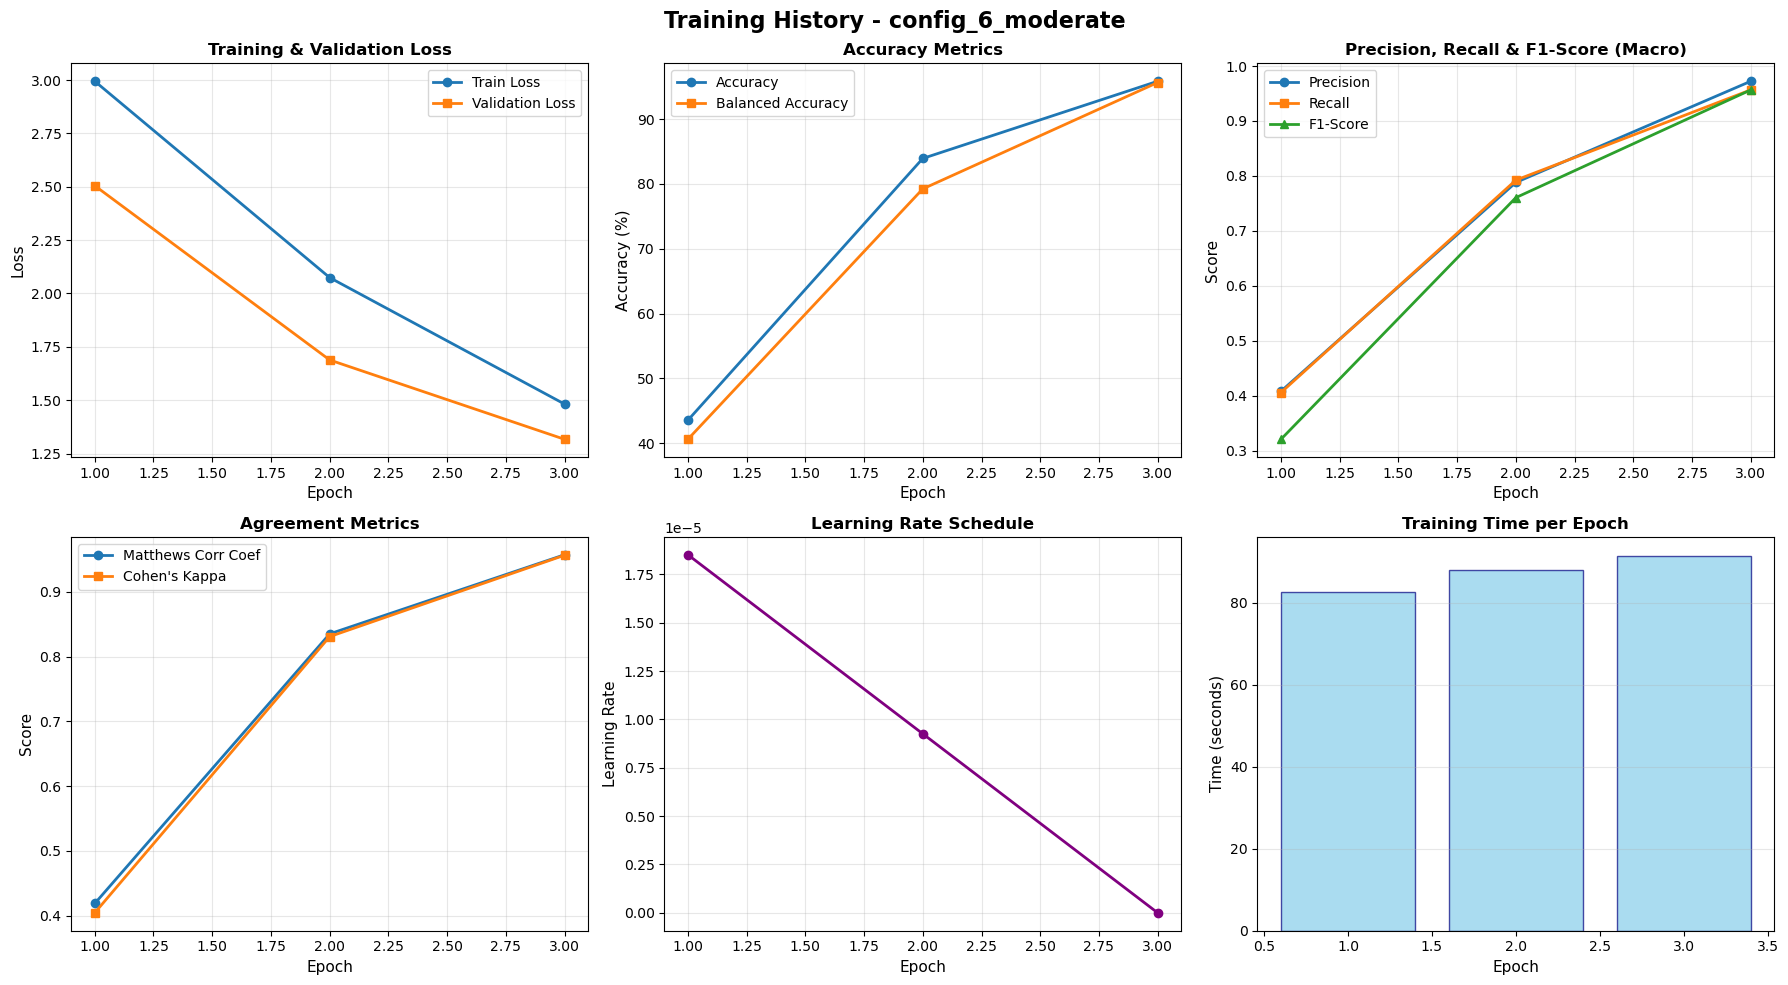

In [34]:
# Visualize training history
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Training History - {SELECTED_CONFIG}', fontsize=16, fontweight='bold')

# Plot 1: Loss curves
axes[0, 0].plot(range(1, EPOCHS+1), training_history['train_losses'], 
                marker='o', label='Train Loss', linewidth=2, markersize=6)
axes[0, 0].plot(range(1, EPOCHS+1), training_history['val_losses'], 
                marker='s', label='Validation Loss', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].set_title('Training & Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy metrics
axes[0, 1].plot(range(1, EPOCHS+1), [a*100 for a in training_history['val_accuracy']], 
                marker='o', label='Accuracy', linewidth=2, markersize=6)
axes[0, 1].plot(range(1, EPOCHS+1), [a*100 for a in training_history['val_balanced_accuracy']], 
                marker='s', label='Balanced Accuracy', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=11)
axes[0, 1].set_title('Accuracy Metrics', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Precision, Recall, F1
axes[0, 2].plot(range(1, EPOCHS+1), training_history['val_precision_macro'], 
                marker='o', label='Precision', linewidth=2, markersize=6)
axes[0, 2].plot(range(1, EPOCHS+1), training_history['val_recall_macro'], 
                marker='s', label='Recall', linewidth=2, markersize=6)
axes[0, 2].plot(range(1, EPOCHS+1), training_history['val_f1_macro'], 
                marker='^', label='F1-Score', linewidth=2, markersize=6)
axes[0, 2].set_xlabel('Epoch', fontsize=11)
axes[0, 2].set_ylabel('Score', fontsize=11)
axes[0, 2].set_title('Precision, Recall & F1-Score (Macro)', fontsize=12, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: MCC and Cohen's Kappa
axes[1, 0].plot(range(1, EPOCHS+1), training_history['val_mcc'], 
                marker='o', label='Matthews Corr Coef', linewidth=2, markersize=6)
axes[1, 0].plot(range(1, EPOCHS+1), training_history['val_cohen_kappa'], 
                marker='s', label="Cohen's Kappa", linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Score', fontsize=11)
axes[1, 0].set_title('Agreement Metrics', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Learning rate schedule
axes[1, 1].plot(range(1, EPOCHS+1), training_history['learning_rates'], 
                marker='o', linewidth=2, markersize=6, color='purple')
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Learning Rate', fontsize=11)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].ticklabel_format(axis='y', style='scientific', scilimits=(0,0))

# Plot 6: Epoch training time
axes[1, 2].bar(range(1, EPOCHS+1), training_history['epoch_times'], 
               color='skyblue', edgecolor='navy', alpha=0.7)
axes[1, 2].set_xlabel('Epoch', fontsize=11)
axes[1, 2].set_ylabel('Time (seconds)', fontsize=11)
axes[1, 2].set_title('Training Time per Epoch', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Save the plot
import os
os.makedirs('../outputs/results', exist_ok=True)
plot_path = f'../outputs/results/training_history_{SELECTED_CONFIG}.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Training history plot saved to: {plot_path}")

plt.show()

## Per-Class Performance Analysis

Analyze model performance for each job category to identify strengths and weaknesses.

In [35]:
# Get final predictions for detailed analysis
model.eval()
final_preds = []
final_labels = []

print("Generating final predictions for detailed analysis...")
with torch.no_grad():
    for batch in validation_dataloader:
        b_input_ids, b_attention_masks, b_labels = tuple(t.to(device) for t in batch)
        outputs = model(b_input_ids, attention_mask=b_attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = b_labels.cpu().numpy()
        final_preds.extend(preds)
        final_labels.extend(labels)

# Calculate and display per-class metrics
calculate_per_class_metrics(final_labels, final_preds, category_names)

# Generate detailed classification report
print("\nDetailed Classification Report:")
print("="*90)
from sklearn.metrics import classification_report
report = classification_report(final_labels, final_preds, 
                               target_names=category_names, 
                               digits=4,
                               zero_division=0)
print(report)

Generating final predictions for detailed analysis...

  Per-Class Performance Metrics

Class                             Precision       Recall     F1-Score    Support
------------------------------------------------------------------------------------------
Data Science                         1.0000       1.0000       1.0000          0
HR                                   1.0000       1.0000       1.0000          0
Advocate                             1.0000       0.6667       0.8000          0
Arts                                 1.0000       1.0000       1.0000          0
Web Designing                        1.0000       1.0000       1.0000          0
Mechanical Engineer                  0.6154       1.0000       0.7619          0
Sales                                0.8889       1.0000       0.9412          0
Health and fitness                   1.0000       1.0000       1.0000          0
Civil Engineer                       1.0000       0.4444       0.6154          0
Java Develo

✓ Confusion matrix saved to: ../outputs/results/confusion_matrix_config_6_moderate.png


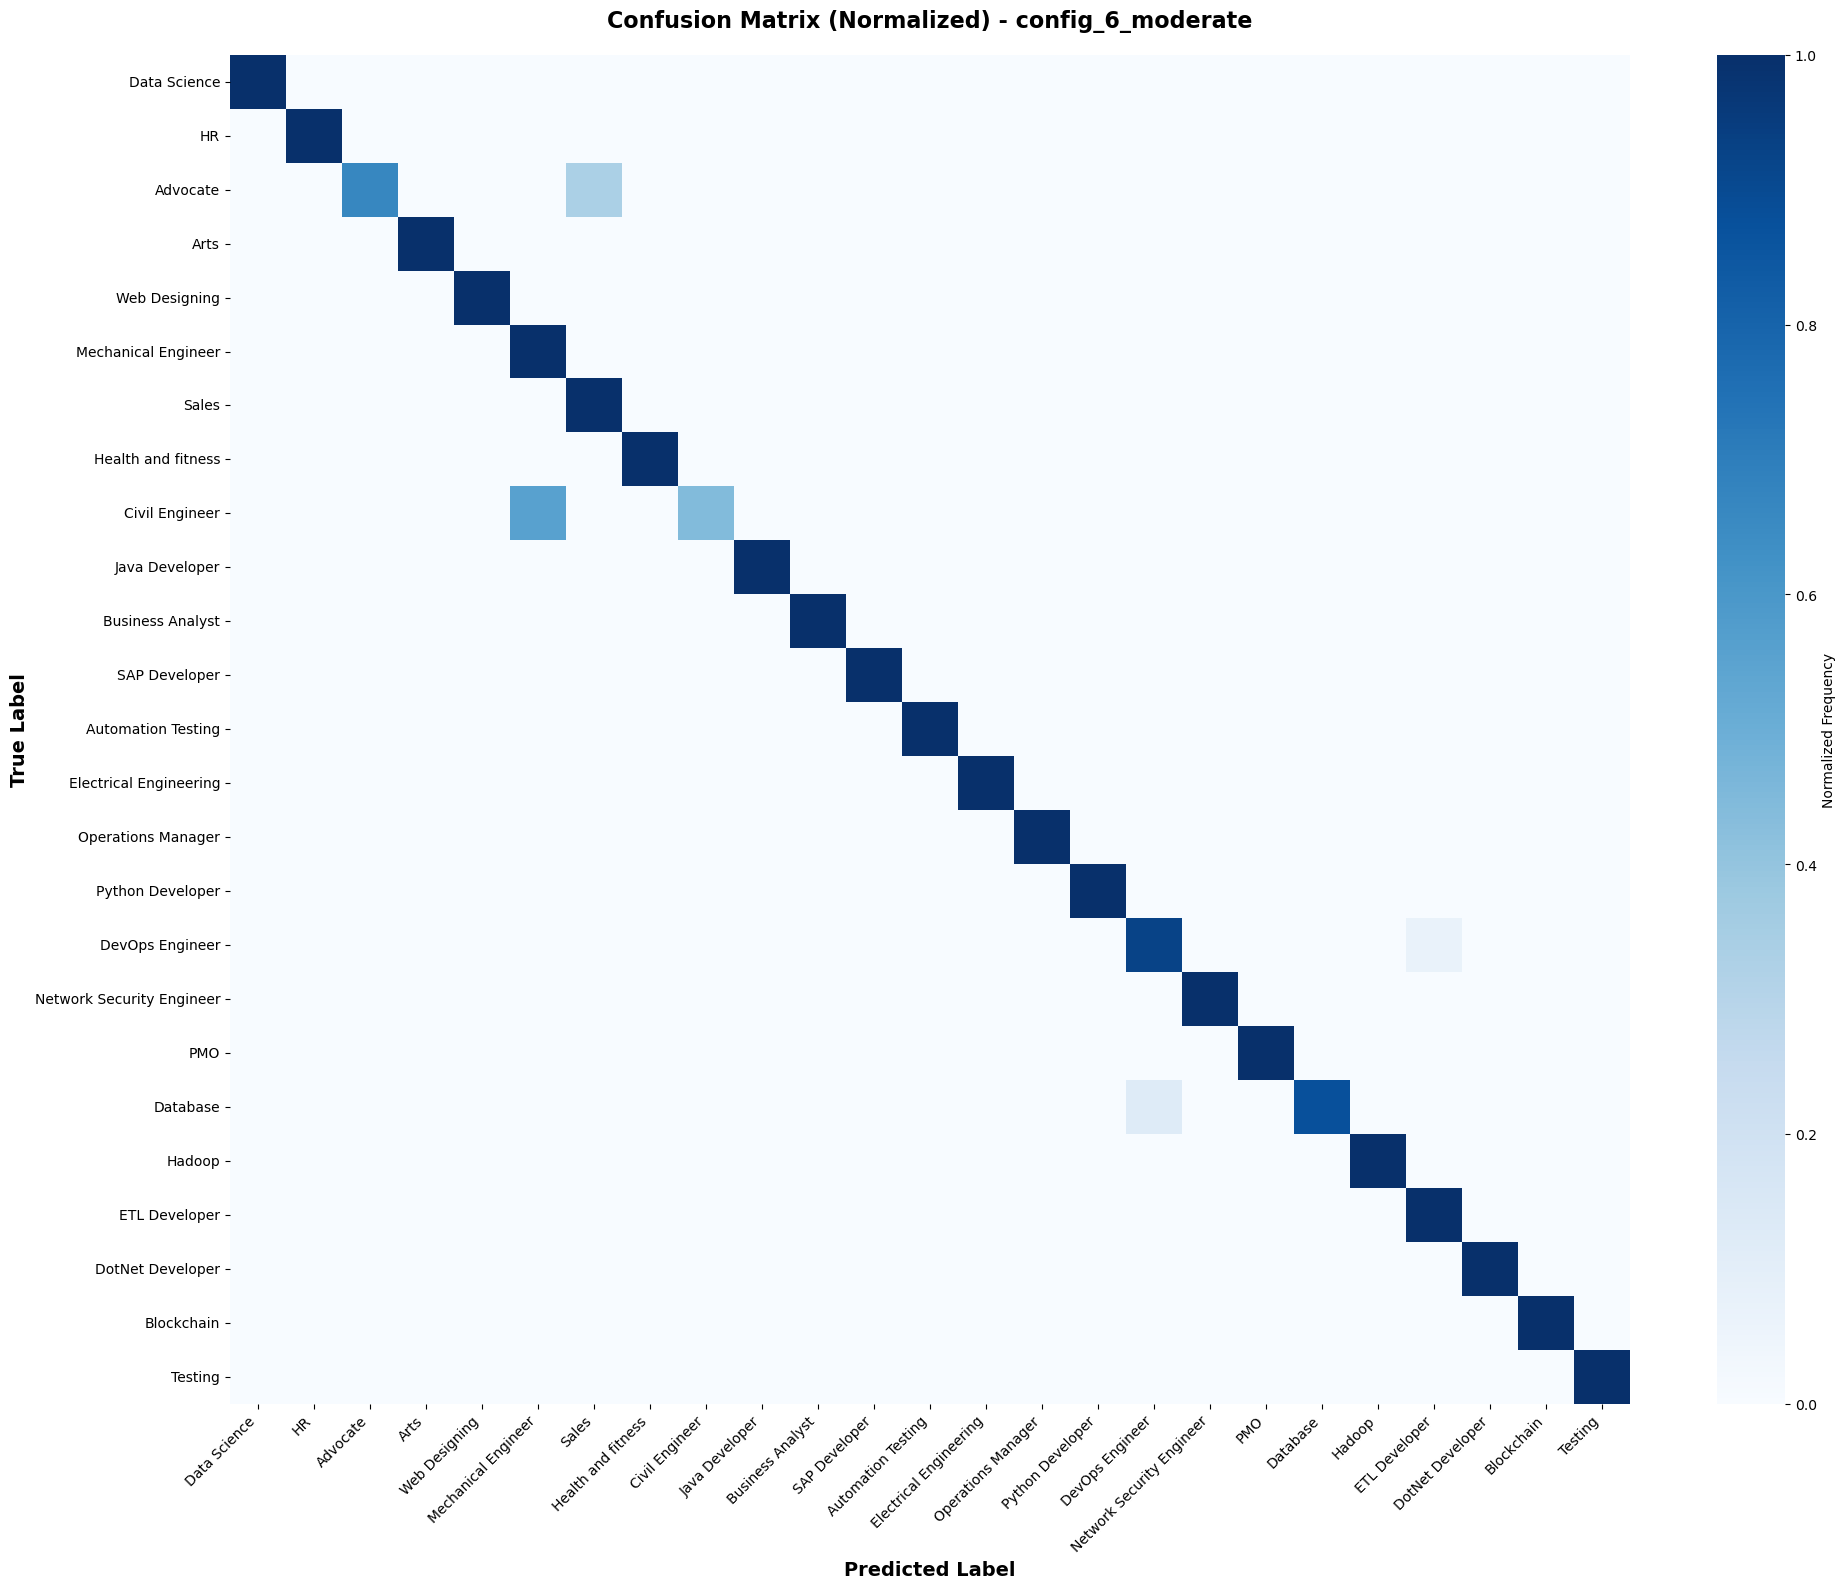


Misclassification Analysis:
Data Science                   Accuracy: 1.0000 | Correct:   5/  5 | Errors:  0
HR                             Accuracy: 1.0000 | Correct:  12/ 12 | Errors:  0
Advocate                       Accuracy: 0.6667 | Correct:   2/  3 | Errors:  1
Arts                           Accuracy: 1.0000 | Correct:   6/  6 | Errors:  0
Web Designing                  Accuracy: 1.0000 | Correct:   5/  5 | Errors:  0
Mechanical Engineer            Accuracy: 1.0000 | Correct:   8/  8 | Errors:  0
Sales                          Accuracy: 1.0000 | Correct:   8/  8 | Errors:  0
Health and fitness             Accuracy: 1.0000 | Correct:   7/  7 | Errors:  0
Civil Engineer                 Accuracy: 0.4444 | Correct:   4/  9 | Errors:  5
Java Developer                 Accuracy: 1.0000 | Correct:  15/ 15 | Errors:  0
Business Analyst               Accuracy: 1.0000 | Correct:   4/  4 | Errors:  0
SAP Developer                  Accuracy: 1.0000 | Correct:   7/  7 | Errors:  0
Automation 

In [36]:
# Visualize confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(final_labels, final_preds)

# Create confusion matrix plot
fig, ax = plt.subplots(figsize=(20, 16))

# Normalize confusion matrix for better visualization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues', 
            xticklabels=category_names, yticklabels=category_names,
            cbar_kws={'label': 'Normalized Frequency'}, ax=ax)

ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
ax.set_title(f'Confusion Matrix (Normalized) - {SELECTED_CONFIG}', 
             fontsize=16, fontweight='bold', pad=20)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save confusion matrix
cm_path = f'../outputs/results/confusion_matrix_{SELECTED_CONFIG}.png'
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"✓ Confusion matrix saved to: {cm_path}")

plt.show()

# Show misclassification statistics
print("\nMisclassification Analysis:")
print("="*70)
correct_per_class = np.diag(cm)
total_per_class = cm.sum(axis=1)
accuracy_per_class = correct_per_class / total_per_class

for i, (cat, acc) in enumerate(zip(category_names, accuracy_per_class)):
    misclassified = total_per_class[i] - correct_per_class[i]
    print(f"{cat:<30} Accuracy: {acc:.4f} | Correct: {correct_per_class[i]:>3}/{total_per_class[i]:>3} | Errors: {int(misclassified):>2}")
    
print("="*70)

## Step 11: Save the Trained Model

In [39]:
# Save the trained model and tokenizer
import os
from datetime import datetime
import json

# Create model save directory
model_save_path = r'f:\shaan\models\saved_models\resume_analyser_bert'
os.makedirs(model_save_path, exist_ok=True)

# Save the model
model.save_pretrained(model_save_path)
print(f"✓ Model saved to: {model_save_path}")

# Save the tokenizer
tokenizer.save_pretrained(model_save_path)
print(f"✓ Tokenizer saved to: {model_save_path}")

# Save comprehensive training metrics
best_epoch = np.argmax(training_history['val_accuracy']) + 1
metrics = {
    'configuration': SELECTED_CONFIG,
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'learning_rate': LR,
        'warmup_ratio': WARMUP_RATIO,
        'weight_decay': WEIGHT_DECAY,
        'max_grad_norm': MAX_GRAD_NORM
    },
    'training_history': {
        'train_losses': [float(x) for x in training_history['train_losses']],
        'val_losses': [float(x) for x in training_history['val_losses']],
        'val_accuracy': [float(x) for x in training_history['val_accuracy']],
        'val_balanced_accuracy': [float(x) for x in training_history['val_balanced_accuracy']],
        'val_precision_macro': [float(x) for x in training_history['val_precision_macro']],
        'val_recall_macro': [float(x) for x in training_history['val_recall_macro']],
        'val_f1_macro': [float(x) for x in training_history['val_f1_macro']],
        'val_mcc': [float(x) for x in training_history['val_mcc']],
        'val_cohen_kappa': [float(x) for x in training_history['val_cohen_kappa']],
        'epoch_times': [float(x) for x in training_history['epoch_times']],
        'learning_rates': [float(x) for x in training_history['learning_rates']]
    },
    'best_performance': {
        'best_epoch': int(best_epoch),
        'best_accuracy': float(training_history['val_accuracy'][best_epoch-1]),
        'best_balanced_accuracy': float(training_history['val_balanced_accuracy'][best_epoch-1]),
        'best_f1_macro': float(training_history['val_f1_macro'][best_epoch-1]),
        'best_mcc': float(training_history['val_mcc'][best_epoch-1])
    },
    'final_performance': {
        'final_accuracy': float(training_history['val_accuracy'][-1]),
        'final_balanced_accuracy': float(training_history['val_balanced_accuracy'][-1]),
        'final_f1_macro': float(training_history['val_f1_macro'][-1]),
        'final_train_loss': float(training_history['train_losses'][-1]),
        'final_val_loss': float(training_history['val_losses'][-1]),
        'final_mcc': float(training_history['val_mcc'][-1])
    },
    'training_time': {
        'total_minutes': float(total_training_time / 60),
        'avg_epoch_seconds': float(np.mean(training_history['epoch_times']))
    },
    'model_info': {
        'num_labels': 25,
        'base_model': 'bert-base-uncased',
        'total_parameters': sum(p.numel() for p in model.parameters()),
        'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad)
    },
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

metrics_file = os.path.join(model_save_path, f'training_metrics_{SELECTED_CONFIG}.json')
with open(metrics_file, 'w') as f:
    json.dump(metrics, f, indent=4)
print(f"✓ Training metrics saved to: {metrics_file}")

# Save enhanced model info
info = f"""
Resume Analyser - BERT Model
=============================

Configuration: {SELECTED_CONFIG}
Description: {HYPERPARAMETER_CONFIGS[SELECTED_CONFIG]['description']}

Model Details:
- Base Model: bert-base-uncased
- Task: Multi-class Text Classification (25 job categories)
- Total Parameters: {metrics['model_info']['total_parameters']:,}
- Trainable Parameters: {metrics['model_info']['trainable_parameters']:,}

Hyperparameters:
- Epochs: {EPOCHS}
- Batch Size: {BATCH_SIZE}
- Learning Rate: {LR}
- Warmup Ratio: {WARMUP_RATIO}
- Weight Decay: {WEIGHT_DECAY}
- Max Gradient Norm: {MAX_GRAD_NORM}
- Optimizer: AdamW
- Scheduler: Linear warmup

Best Performance (Epoch {best_epoch}):
- Validation Accuracy: {training_history['val_accuracy'][best_epoch-1]:.4f} ({training_history['val_accuracy'][best_epoch-1]*100:.2f}%)
- Balanced Accuracy: {training_history['val_balanced_accuracy'][best_epoch-1]:.4f}
- F1-Score (Macro): {training_history['val_f1_macro'][best_epoch-1]:.4f}
- Precision (Macro): {training_history['val_precision_macro'][best_epoch-1]:.4f}
- Recall (Macro): {training_history['val_recall_macro'][best_epoch-1]:.4f}
- MCC Score: {training_history['val_mcc'][best_epoch-1]:.4f}
- Cohen's Kappa: {training_history['val_cohen_kappa'][best_epoch-1]:.4f}

Final Performance:
- Validation Accuracy: {training_history['val_accuracy'][-1]:.4f} ({training_history['val_accuracy'][-1]*100:.2f}%)
- Training Loss: {training_history['train_losses'][-1]:.4f}
- Validation Loss: {training_history['val_losses'][-1]:.4f}

Training Time:
- Total: {total_training_time/60:.2f} minutes
- Average per Epoch: {np.mean(training_history['epoch_times']):.2f} seconds

Training Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Device: {device}
"""

info_file = os.path.join(model_save_path, f'model_info_{SELECTED_CONFIG}.txt')
with open(info_file, 'w') as f:
    f.write(info)
print(f"✓ Model info saved to: {info_file}")

print(f"\n{'='*80}")
print("Model successfully saved with comprehensive metrics!")
print(f"{'='*80}")
print("\nSaved files:")
print(f"  1. Model weights: pytorch_model.bin / model.safetensors")
print(f"  2. Model config: config.json")
print(f"  3. Tokenizer files: tokenizer_config.json, vocab.txt")
print(f"  4. Training metrics: {os.path.basename(metrics_file)}")
print(f"  5. Model info: {os.path.basename(info_file)}")
print(f"  6. Plots: training_history_{SELECTED_CONFIG}.png, confusion_matrix_{SELECTED_CONFIG}.png")
print(f"\nModel ready for deployment and inference!")

✓ Model saved to: f:\shaan\models\saved_models\resume_analyser_bert
✓ Tokenizer saved to: f:\shaan\models\saved_models\resume_analyser_bert
✓ Training metrics saved to: f:\shaan\models\saved_models\resume_analyser_bert\training_metrics_config_6_moderate.json
✓ Model info saved to: f:\shaan\models\saved_models\resume_analyser_bert\model_info_config_6_moderate.txt

Model successfully saved with comprehensive metrics!

Saved files:
  1. Model weights: pytorch_model.bin / model.safetensors
  2. Model config: config.json
  3. Tokenizer files: tokenizer_config.json, vocab.txt
  4. Training metrics: training_metrics_config_6_moderate.json
  5. Model info: model_info_config_6_moderate.txt
  6. Plots: training_history_config_6_moderate.png, confusion_matrix_config_6_moderate.png

Model ready for deployment and inference!


## Compare Different Hyperparameter Configurations (Optional)

Load and compare results from different hyperparameter configurations to find the best one.

Comparing Hyperparameter Configurations:

Rank  Configuration            Best Acc    Final Acc   Best F1     Best MCC    Time (min)  
----------------------------------------------------------------------------------------------------
1     config_1_baseline        1.0000      1.0000      1.0000      1.0000      7.19        
2     config_6_moderate        0.9585      0.9585      0.9565      0.9572      4.37        
----------------------------------------------------------------------------------------------------

✓ Comparison plot saved to: ../outputs/results/hyperparameter_comparison.png


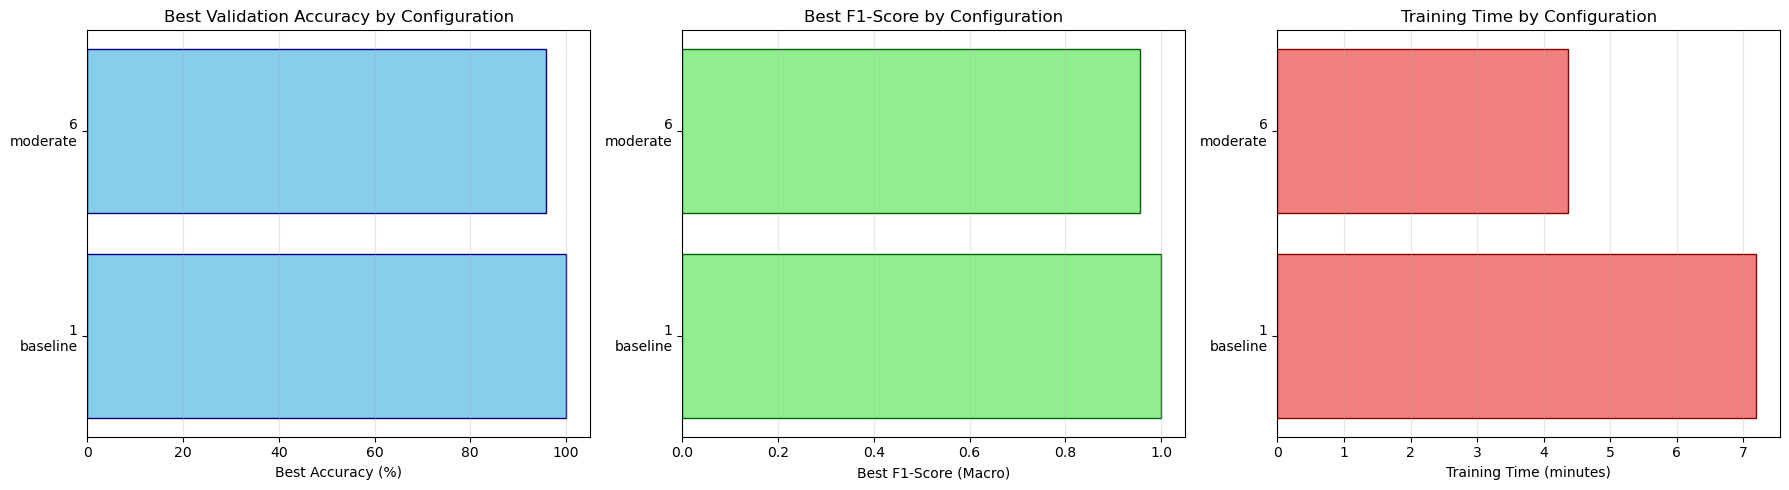


🏆 Best Configuration: config_1_baseline
   Description: Baseline configuration
   Best Accuracy: 1.0000 (100.00%)
   Best F1-Score: 1.0000


In [38]:
# Compare results from different configurations
# Run this after training with multiple configurations

import glob
import json

# Find all saved metric files
metrics_files = glob.glob(os.path.join(model_save_path, 'training_metrics_*.json'))

if len(metrics_files) > 1:
    print("Comparing Hyperparameter Configurations:")
    print("="*100)
    
    all_results = []
    for file in metrics_files:
        with open(file, 'r') as f:
            data = json.load(f)
            config_name = data['configuration']
            all_results.append({
                'config': config_name,
                'description': HYPERPARAMETER_CONFIGS[config_name]['description'],
                'best_accuracy': data['best_performance']['best_accuracy'],
                'best_f1': data['best_performance']['best_f1_macro'],
                'best_mcc': data['best_performance']['best_mcc'],
                'final_accuracy': data['final_performance']['final_accuracy'],
                'training_time': data['training_time']['total_minutes'],
                'epochs': data['hyperparameters']['epochs'],
                'lr': data['hyperparameters']['learning_rate']
            })
    
    # Sort by best accuracy
    all_results.sort(key=lambda x: x['best_accuracy'], reverse=True)
    
    # Print comparison table
    print(f"\n{'Rank':<6}{'Configuration':<25}{'Best Acc':<12}{'Final Acc':<12}{'Best F1':<12}{'Best MCC':<12}{'Time (min)':<12}")
    print("-"*100)
    
    for rank, result in enumerate(all_results, 1):
        print(f"{rank:<6}{result['config']:<25}{result['best_accuracy']:<12.4f}{result['final_accuracy']:<12.4f}"
              f"{result['best_f1']:<12.4f}{result['best_mcc']:<12.4f}{result['training_time']:<12.2f}")
    
    print("-"*100)
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    configs = [r['config'].replace('config_', '').replace('_', '\n') for r in all_results]
    best_accs = [r['best_accuracy']*100 for r in all_results]
    best_f1s = [r['best_f1'] for r in all_results]
    times = [r['training_time'] for r in all_results]
    
    # Plot 1: Best accuracy
    axes[0].barh(configs, best_accs, color='skyblue', edgecolor='navy')
    axes[0].set_xlabel('Best Accuracy (%)')
    axes[0].set_title('Best Validation Accuracy by Configuration')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Plot 2: Best F1-score
    axes[1].barh(configs, best_f1s, color='lightgreen', edgecolor='darkgreen')
    axes[1].set_xlabel('Best F1-Score (Macro)')
    axes[1].set_title('Best F1-Score by Configuration')
    axes[1].grid(axis='x', alpha=0.3)
    
    # Plot 3: Training time
    axes[2].barh(configs, times, color='lightcoral', edgecolor='darkred')
    axes[2].set_xlabel('Training Time (minutes)')
    axes[2].set_title('Training Time by Configuration')
    axes[2].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    
    comp_path = '../outputs/results/hyperparameter_comparison.png'
    plt.savefig(comp_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Comparison plot saved to: {comp_path}")
    
    plt.show()
    
    print(f"\n🏆 Best Configuration: {all_results[0]['config']}")
    print(f"   Description: {all_results[0]['description']}")
    print(f"   Best Accuracy: {all_results[0]['best_accuracy']:.4f} ({all_results[0]['best_accuracy']*100:.2f}%)")
    print(f"   Best F1-Score: {all_results[0]['best_f1']:.4f}")
    
else:
    print("Train with multiple configurations to enable comparison.")
    print("Change SELECTED_CONFIG and re-run training cells to test different hyperparameters.")